In [3]:
import pandas as pd
import os

In [2]:
file_path = './csv/'
file_name_frame = 'frame_{:03d}.csv'

In [4]:
data_frames = []

for i in range(92):
    file_name = file_name_frame.format(i)
    full_path = os.path.join(file_path, file_name)
    
    df = pd.read_csv(full_path, usecols=['id', 'centroid_row', 'centroid_col'])
    
    df['frame'] = i
    
    data_frames.append(df)



In [5]:
# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(all_data.head(10))

   id  centroid_row  centroid_col  frame
0   1           182           463      0
1  10            33           169      0
2  12            22           192      0
3  16            44           250      0
4  22            21           681      0
5  25           145           361      0
6  30           169           409      0
7  41           160           513      0
8  50           279           246      0
9  51           300           278      0


In [6]:
print(len(all_data))

8639


* Đếm số cell có trong mỗi frame để xem cần fill cell thiếu ntn 

In [9]:
unique_counts = all_data.groupby('frame')['id'].nunique()
print('number of cell in each frame\n',unique_counts)

number of cell in each frame
 frame
0      43
1      43
2      43
3      46
4      47
     ... 
87    134
88    134
89    133
90    133
91    137
Name: id, Length: 92, dtype: int64


In [10]:
print(unique_counts.unique())

[ 43  46  47  48  49  51  52  54  57  60  61  62  63  65  64  66  67  70
  69  71  72  73  74  76  78  82  83  86  89  93  96  97  99 100 102 106
 109 110 113 114 115 116 117 119 121 122 123 125 124 126 128 127 129 130
 132 134 133 137]


* tối thiểu 1 frame gồm 43 cell, tối đa 137 cell.
 

* đếm xem liệu tất cả id được sử dụng 

In [19]:
# Find the minimum and maximum values of seg_label
min_id_label = all_data['id'].min()
max_id_label = all_data['id'].max()
print(f'min id:{min_id_label}, max id:{max_id_label}')


min id:1, max id:389


In [17]:
print(len(all_data['id'].unique()))

265


+ max id = 389, nhưng unique chỉ có 265 -> 124 value không dùng trong khoảng 1-389

In [26]:
unique_id = all_data['id'].sort_values().unique()
print(unique_id)

[  1   8   9  10  12  14  15  16  18  19  20  21  22  23  24  25  28  29
  30  32  33  35  36  37  39  40  41  43  44  45  46  48  49  50  51  53
  54  55  58  59  61  62  63  65  66  68  69  71  72  74  75  76  78  79
  80  82  84  85  86  88  89  91  92  93  94  96  97  98 100 101 102 104
 105 107 108 110 111 112 114 115 117 118 120 121 123 124 125 127 128 130
 131 132 133 135 136 137 139 140 141 143 144 146 147 149 150 151 153 154
 156 157 159 160 161 163 164 167 168 169 171 172 174 175 177 179 180 182
 183 185 186 188 189 190 192 193 195 196 197 199 200 202 203 204 207 208
 211 212 214 215 217 218 220 221 223 224 225 227 228 230 231 233 234 238
 239 241 242 244 245 247 248 257 259 260 262 263 265 266 268 269 270 272
 273 275 276 278 279 280 282 284 286 287 288 290 291 293 294 296 297 299
 300 302 303 304 305 307 308 310 311 313 314 315 317 318 321 322 324 325
 326 328 329 331 332 333 335 336 337 340 341 343 344 346 347 349 350 351
 352 353 355 356 358 359 361 362 363 364 365 366 36

# Fill missing data

In [33]:
def fill_missing_data(df, unique_ids):
    # Tạo DataFrame mới với tất cả các frame và unique_id
    all_frames = df['frame'].unique()
    all_combinations = pd.MultiIndex.from_product([all_frames, unique_ids], 
                                                 names=['frame', 'id'])
    complete_df = pd.DataFrame(index=all_combinations).reset_index()
    
    # Merge với dữ liệu gốc
    complete_df = complete_df.merge(df, on=['frame', 'id'], how='left')
    
    # Sắp xếp theo frame và id
    complete_df = complete_df.sort_values(['id', 'frame'])
    
    # Fill dữ liệu bị thiếu cho từng id
    for cell_id in unique_ids:
        cell_data = complete_df[complete_df['id'] == cell_id].copy()
        
        # Tìm các frame có dữ liệu
        frames_with_data = cell_data[cell_data['centroid_row'].notna()]['frame'].values
        
        if len(frames_with_data) == 0:
            continue
            
        # Với mỗi frame thiếu dữ liệu
        for frame in cell_data['frame'].unique():
            if frame not in frames_with_data:
                # Tìm frame gần nhất có dữ liệu
                left_frames = frames_with_data[frames_with_data < frame]
                right_frames = frames_with_data[frames_with_data > frame]
                
                if len(left_frames) > 0:
                    # Lấy dữ liệu từ frame trước đó
                    prev_frame = left_frames[-1]
                    prev_data = cell_data[cell_data['frame'] == prev_frame].iloc[0]
                    complete_df.loc[(complete_df['frame'] == frame) & 
                                  (complete_df['id'] == cell_id), 
                                  ['centroid_row', 'centroid_col']] = [prev_data['centroid_row'], 
                                                                      prev_data['centroid_col']]
                elif len(right_frames) > 0:
                    # Lấy dữ liệu từ frame sau đó
                    next_frame = right_frames[0]
                    next_data = cell_data[cell_data['frame'] == next_frame].iloc[0]
                    complete_df.loc[(complete_df['frame'] == frame) & 
                                  (complete_df['id'] == cell_id), 
                                  ['centroid_row', 'centroid_col']] = [next_data['centroid_row'], 
                                                                      next_data['centroid_col']]
    
    return complete_df

In [34]:
complete_df = fill_missing_data(all_data,unique_ids=unique_id)

In [35]:
complete_df.head()

,frame,id,centroid_row,centroid_col
0,0,1,182.0,463.0
265,1,1,180.0,466.0
530,2,1,177.0,466.0
795,3,1,176.0,467.0
1060,4,1,168.0,467.0


In [36]:
unique_counts = complete_df.groupby('frame')['id'].nunique()
print('number of cell in each frame\n',unique_counts)

number of cell in each frame
 frame
0     265
1     265
2     265
3     265
4     265
     ... 
87    265
88    265
89    265
90    265
91    265
Name: id, Length: 92, dtype: int64


# Ảnh dữ liệu ban đầu 

C:\Users\Admin\AppData\Local\Temp\ipykernel_11736\737733787.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cell_data['centroid_col'],


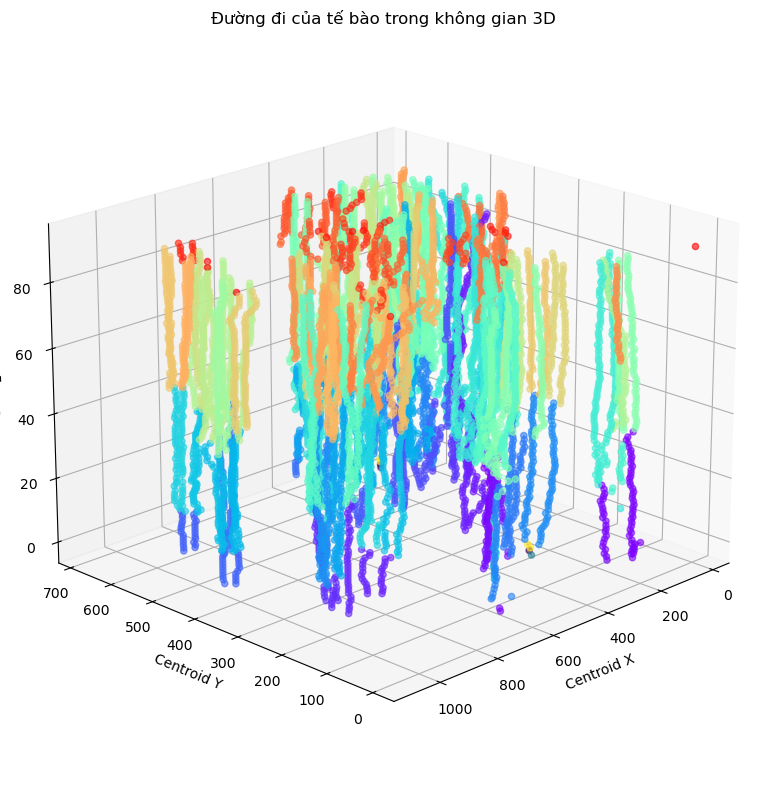

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Tạo figure và axes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Lấy danh sách các ID duy nhất
unique_cells = all_data['id'].unique()

# Tạo màu ngẫu nhiên cho mỗi tế bào
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_cells)))

# Vẽ đường đi cho từng tế bào
for idx, cell_id in enumerate(unique_cells):
    # Lọc dữ liệu cho tế bào hiện tại
    cell_data = all_data[all_data['id'] == cell_id]
    
    # Vẽ đường đi
    ax.plot(cell_data['centroid_col'], 
            cell_data['centroid_row'], 
            cell_data['frame'],
            c=colors[idx],
            alpha=0.6,
            linewidth=1)
    
    # Vẽ điểm cho mỗi frame
    ax.scatter(cell_data['centroid_col'],
               cell_data['centroid_row'],
               cell_data['frame'],
               c=colors[idx],
               s=20,
               alpha=0.6)

# Tùy chỉnh các trục và nhãn
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_zlabel('Frame')
ax.set_title('Đường đi của tế bào trong không gian 3D')

# Đảo ngược trục Y để phù hợp với hệ tọa độ ảnh
ax.invert_yaxis()

# Thêm grid
ax.grid(True)

# Điều chỉnh góc nhìn
ax.view_init(elev=20, azim=45)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# Ảnh dữ liệu sau khi fill

C:\Users\Admin\AppData\Local\Temp\ipykernel_11736\1467013066.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cell_data['centroid_col'],


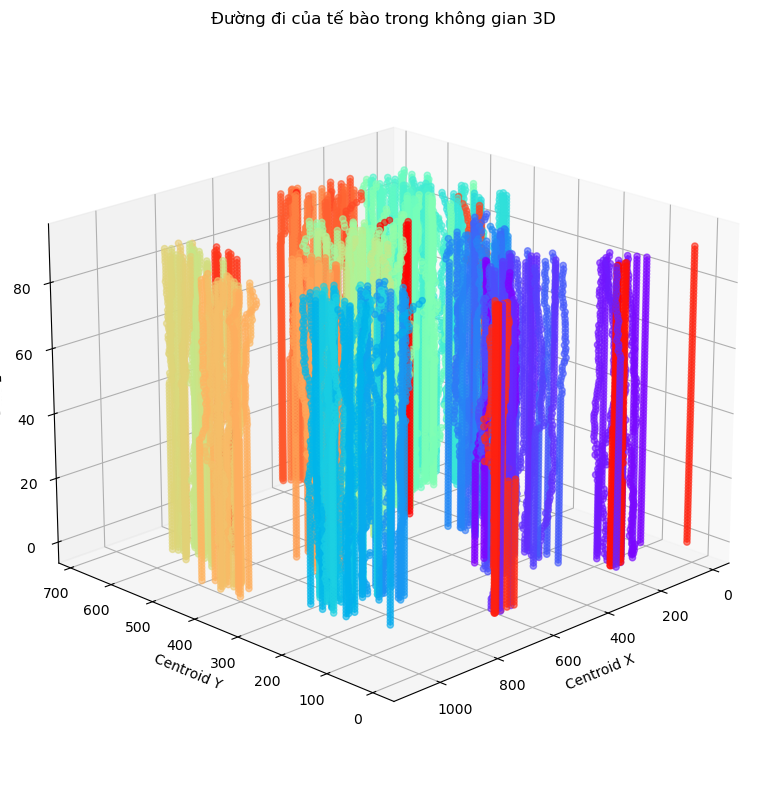

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Tạo figure và axes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Lấy danh sách các ID duy nhất
unique_cells = complete_df['id'].unique()

# Tạo màu ngẫu nhiên cho mỗi tế bào
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_cells)))

# Vẽ đường đi cho từng tế bào
for idx, cell_id in enumerate(unique_cells):
    # Lọc dữ liệu cho tế bào hiện tại
    cell_data = complete_df[complete_df['id'] == cell_id]
    
    # Vẽ đường đi
    ax.plot(cell_data['centroid_col'], 
            cell_data['centroid_row'], 
            cell_data['frame'],
            c=colors[idx],
            alpha=0.6,
            linewidth=1)
    
    # Vẽ điểm cho mỗi frame
    ax.scatter(cell_data['centroid_col'],
               cell_data['centroid_row'],
               cell_data['frame'],
               c=colors[idx],
               s=20,
               alpha=0.6)

# Tùy chỉnh các trục và nhãn
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_zlabel('Frame')
ax.set_title('Đường đi của tế bào trong không gian 3D')

# Đảo ngược trục Y để phù hợp với hệ tọa độ ảnh
ax.invert_yaxis()

# Thêm grid
ax.grid(True)

# Điều chỉnh góc nhìn
ax.view_init(elev=20, azim=45)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()